In [123]:
import multiprocessing
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


## Standard fixed pricing with $p_1=p_2=...=p_N=1-\frac{k}{N}$:

In [124]:
def fixed_pricing_revenue(lims: Tuple[int,int]) -> Tuple[List[int],List[int], List[int], List[int]]:
    N_min, N_max = lims
    standard_revenues = []
    max_revenue = []
    n_vals, k_vals = [], []
    for N in range(N_min,N_max):
        for k in range(1,N//2): # k < N/2
            standard_price = 1 - k/N
            tickets_remaining = k
            revenue = 0.0
            for costumer in range(N):
                if tickets_remaining > 0:
                    v_i = np.random.uniform(low=0.0,high=1)
                    if v_i >= standard_price:
                        revenue += standard_price
                        tickets_remaining -= 1
                else:
                    break
            max_revenue.append(standard_price * k)
            standard_revenues.append(revenue)
            n_vals.append(N)
            k_vals.append(k)
    return standard_revenues, max_revenue, n_vals, k_vals

def variable_pricing_revenue(lims: Tuple[int,int]) -> Tuple[List[int],List[int], List[int], List[int]]:
    N_min, N_max = lims
    standard_revenues = []
    max_revenue = []
    n_vals, k_vals = [], []
    for N in range(N_min,N_max):
        for k in range(1,N//2): # k < N/2
            standard_price = 1 - k/N
            tickets_remaining = k
            revenue = 0.0
            for costumer in range(N):
                if tickets_remaining > 0:
                    v_i = np.random.uniform(low=0.0,high=1)
                    if v_i >= standard_price:
                        revenue += standard_price
                        tickets_remaining -= 1
                else:
                    break
            max_revenue.append(standard_price * k)
            standard_revenues.append(revenue)
            n_vals.append(N)
            k_vals.append(k)
    return standard_revenues, max_revenue, n_vals, k_vals



#### Doing it without parallelization:

In [125]:
%%time
N_min, N_max_initial = 10, 1000
standard_revenues, max_revenue, n_vals, k_vals = fixed_pricing_revenue(lims=(N_min,N_max_initial))


CPU times: total: 1min 12s
Wall time: 3min 8s


#### Doing it with parallelization:

In [126]:
num_cores = multiprocessing.cpu_count()
print("Number of available CPU cores: ", num_cores)

Number of available CPU cores:  16


In [127]:
########################################################################################
######## Partitioning into even sized intervals -> One interval pr. core in CPU ########
########################################################################################
# Calculate the range_size that is a multiple of num_cores
range_size = ((N_max_initial - N_min) // num_cores) * num_cores
# Adjust N_max value
N_max_adjusted = N_min + range_size
# Calculate interval size
Interval_size = int((N_max_adjusted - N_min) / num_cores)
# Calculate partitions
partitions = [(N_min + Interval_size * i, N_min + Interval_size * (i+1)) for i in range(num_cores)]
print(f"Adjusted N_max from {N_max_initial} to {N_max_adjusted} and now how {num_cores} evenly sized intervals of size {Interval_size}.")

Adjusted N_max from 1000 to 986 and now how 16 evenly sized intervals of size 61.


In [128]:
%%time
backend = 'loky'
# N.B. result is list of tuples (standard_revenues, max_revenue, n_vals, k_vals)
result = Parallel(n_jobs=num_cores, backend=backend)(delayed(fixed_pricing_revenue)(partitions[partition]) for partition in range(num_cores))

CPU times: total: 15.6 ms
Wall time: 49.3 s


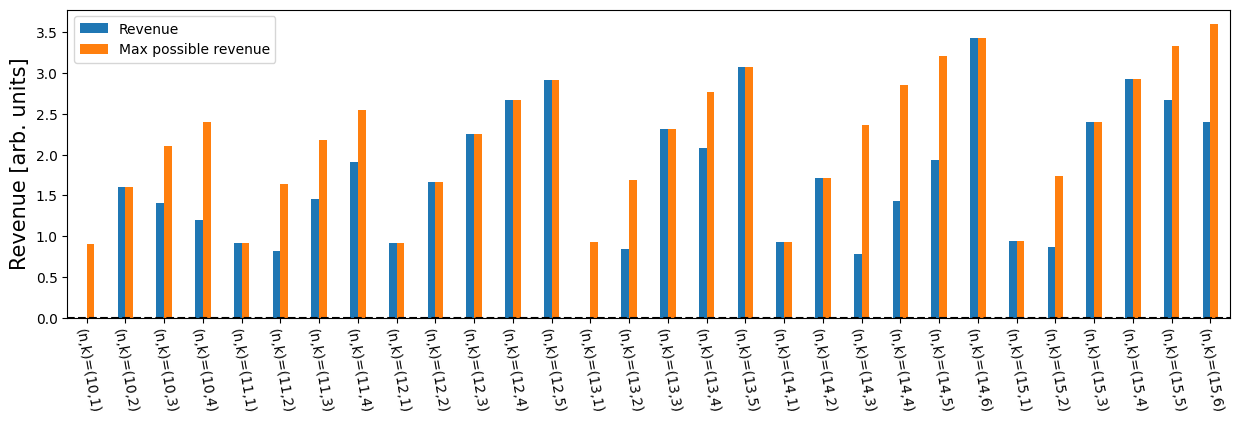

In [155]:
view_size = 30

fig, ax = plt.subplots(1,1,figsize=(15,4))
trials = np.array([i+1 for i in range(len(standard_revenues[:view_size]))])

width = 0.2
ax.bar(trials[:view_size] - width/2,standard_revenues[:view_size],width,label="Revenue")
ax.bar(trials[:view_size] + width/2,max_revenue[:view_size],width,label="Max possible revenue")
ax.hlines(0,0.5,np.max(trials[:view_size])+0.5,color='black',ls='--')

ax.set_xlim(0.5,np.max(trials[:view_size])+0.5)
ax.set_ylabel("Revenue [arb. units]",size=15)

ax.set_xticks(trials[:view_size])
x_tick_labels = ["(n,k)="f"({n_vals[i]},{k_vals[i]})" for i in range(len(trials[:view_size]))]
ax.set_xticklabels(x_tick_labels, rotation=280)

ax.legend()
plt.show()

#### considering how relative % of max revenue is across all trials, i.e. (Rev/Max_rev):

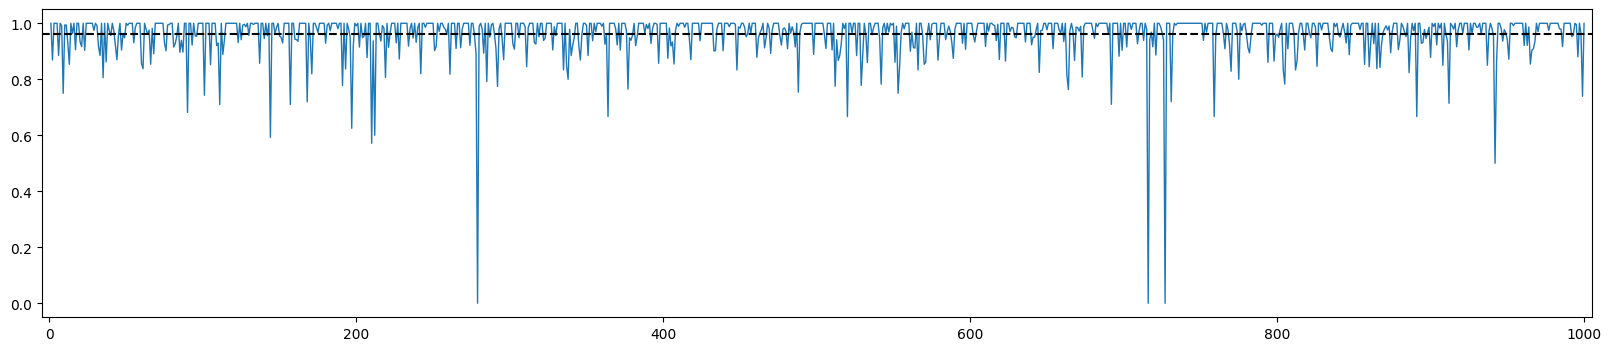

In [157]:
view_size = 1000
fractions = np.random.permutation([standard_revenues[i] / max_revenue[i] for i in range(len(standard_revenues))])[:view_size]
trials = [i+1 for i in range(len(standard_revenues))][:view_size]
fig, ax = plt.subplots(1,1, figsize=(20,4))

ax.plot(trials,fractions, lw=1)
buffer = 0.005*view_size
ax.set_xlim(-buffer,np.max(trials)+buffer)
print("Avg. fraction of max revenue: ", )
ax.hlines(np.mean(fractions),-buffer,np.max(trials)+buffer,ls='--',color='black')
plt.show()